# Quantum Channel Discrimination

Date : December 30, 2021

This notebook contains material supporting a paper, currently titled *Five Starter Pieces: Quantum Information Science via Semi-definite Programs*, by Vikesh Siddhu (vsiddhu@protonmail.com) and Sridhar Tayur (stayur@cmu.edu). The paper is available on this **[arXiv](http://arxiv.org/abs/2112.08276)** link. The arXiv paper is released there is under the **[arXiv.org perpetual, non-exclusive license](https://arxiv.org/licenses/nonexclusive-distrib/1.0/license.html)**, and this code is released under the **[MIT license](https://opensource.org/licenses/MIT)**.

This notebook depends upon various packages including [numpy](https://numpy.org/) >= 1.19.5, [picos](https://picos-api.gitlab.io/picos/index.html) >= 2.2.55, and [cvxopt](http://cvxopt.org/) >= 1.2.5.
    
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vsiddhu/SDP-Quantum-OR/blob/master/Notebook%203%20-%20Quantum%20Channel%20Discrimination.ipynb)

## Introduction

The probability of correctly distinguishing two unifromly chosen quantum channels $\mathcal{B}_1$ and $\mathcal{B}_2$ without using entangled inputs is
\begin{equation}
 q^* = \frac{1}{2}(1 + \frac{1}{2} \max_{\rho}|| \mathcal{B}_1(\rho) - \mathcal{B}_2(\rho) ||_1)
\end{equation}
and using entangled inputs is
\begin{equation}
s^* = \frac{1}{2}(1 + \frac{1}{2}|| \mathcal{B}_1 -  \mathcal{B}_2 ||_{\diamond}).
\end{equation}
Here $||.||_{\diamond}$ refers to the diamond norm of a linear map discussed next.

### Diamond Norm
A linear map $\mathcal{B}:\hat{ \mathcal{H}_a} \mapsto \hat{ \mathcal{H}_b}$ has diamond norm
$$
|| \mathcal{B} ||_{\diamond} = 
\max_{ ||\rho_{aa}||_1 \leq 1} ||\mathcal{B} \otimes \mathcal{I} (\rho_{aa})||_1
$$
where $\mathcal{I}$ is the identity map on $\hat{ \mathcal{H}_a}$, and $||X||_1 = \rm Tr (\sqrt{X X^{\dagger}})$.
The map $\mathcal{B}$ has a Choi-Jamiolkowski representation
$$
\mathcal{J}_{ba}(\mathcal{B}) = \mathcal{B} \otimes \mathcal{I} (\gamma)
$$
where $\gamma = \sum_{ij} | ii \rangle \langle  jj|$. Using this representation one can compute $|| \mathcal{B} ||_{\diamond}$ as the optimum value of the semi-definite program (SDP)

 \begin{align}
 \begin{aligned}
   \text{maximize} & \;  \frac{1}{2} \; \big( \rm Tr(\mathcal{J}_{ba}(\mathcal{B})X) + \rm Tr(\mathcal{J}_{ba}(\mathcal{B})X)^* \big) & \\
   \text{subject to} & \;
  \begin{pmatrix}
   I_b \otimes \rho_a & X \\
  X^{\dagger} & I_b \otimes \sigma_a
  \end{pmatrix}
  \succeq 0. & \\
  & \rm Tr(\rho_a) = 1, & \\
  & \rm Tr(\sigma_a) = 1, & \\ 
  \text{and} \; & \quad X \in \hat{\mathcal{H}}_{ba},
  \end{aligned}
  \end{align}
  where $I_b$ is the identity matrix on $\mathcal{H}_b$. This SDP problem mentioned above has a dual formulation,

\begin{align}
 \begin{aligned}
  \text{minimize} & \;  \frac{1}{2} \big(  \mu + \nu \big) & \\
  \text{subject to} & \; 
  \begin{pmatrix}
  N_{ba} & -\mathcal{J}_{ba}(\mathcal{B})\\
  -\mathcal{J}_{ba}(\mathcal{B})^{\dagger} & M_{ba}
  \end{pmatrix}
  \succeq 0,\\
  & \; \rm Tr_b (N_{ba}) \preceq \mu I_a \\
  \text{and} & \; \rm Tr_b (M_{ba}) \preceq \nu I_a.
  \end{aligned}
  \end{align}
In what follows, consider various examples of this SDP. 

In [ ]:
%pylab inline

: 

In [3]:
# For Google Colab use, commands installing packages
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# Install PICOS and CVXOPT in Google Colab
if IN_COLAB:
    !pip install -q picos
    !pip install -q cvxopt
    !pip install -q matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.7/510.7 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [4]:
import picos as pic
import cvxopt as cvx
import numpy as np
import matplotlib.pyplot as plt

In [5]:
print('Solvers supported on this installation of picos:', pic.solvers.all_solvers().keys())


Solvers supported on this installation of picos: dict_keys(['cplex', 'cvxopt', 'ecos', 'glpk', 'gurobi', 'mosek', 'mskfsn', 'osqp', 'scip', 'smcp'])


In [6]:
print('Solvers available to picos on this machine :', pic.solvers.available_solvers())

Solvers available to picos on this machine : ['cvxopt', 'ecos', 'osqp']


### Example 1
Diamond norm of a qubit depolarizing channel 
\begin{equation}
    \Delta(\rho) = \lambda \rho + \frac{(1-\lambda)}{2} \rm Tr(\rho) I,
\end{equation}
 where $-1/3 \leq \lambda \leq 1$. The Choi-Jamiolkowski representation of this channel is
 \begin{equation}
 \mathcal{J}_{ba}(\Delta) = 
 \begin{pmatrix}
 (1 + \lambda)/2 & 0 & 0 & \lambda \\
 0 & (1 - \lambda)/2 & 0 & 0 \\
 0 & 0 & (1 - \lambda)/2 & 0 \\
 \lambda & 0 & 0 & (1 + \lambda)/2
 \end{pmatrix}.
 \end{equation}
 The depolarizing channel above can also be written using the parameter $p := 3(1-\lambda)/4$ which lies between $0$ and $1$.

In [11]:
#Example 1 using the primal formulation
def cj_mat(p) -> np.array:
    lmVal = 1.-4.*p/3.
    cjMat = lambda lm : np.array([[(1. + lm)/2, 0., 0., lm],
                        [0., (1. - lm)/2, 0., 0.],
                        [0., 0., (1. - lm)/2, 0.],
                        [lm, 0., 0., (1 + lm)/2]])
    return cjMat(p)

def solve_primal(p) -> tuple[float, ...]:
    cjMat = cj_mat(p)
    lmVal = 1.-4.*p/3.
    da = 2
    db = 2
    gammaBA = cjMat

    #Constants
    #----------
    gammaPic = pic.Constant("gammaBA", gammaBA)
    shpBA = np.shape( gammaBA )
    shpB = np.shape(pic.partial_trace(gammaPic, subsystems=(1),dimensions=2))
    shpA = np.shape(pic.partial_trace(gammaPic, subsystems=(0),dimensions=2))
    iMatB = pic.Constant('Ib', np.eye(shpB[0]))

    #Variables
    #----------
    rhoPic = pic.HermitianVariable("rhoA", shpA)
    sigPic = pic.HermitianVariable("sigA", shpB)
    XPic = pic.ComplexVariable("X", shpBA)

    prob1P = pic.Problem()
    
    #Constraint
    #----------
    prob1P.add_constraint(((iMatB @ rhoPic  & XPic) // (XPic.H & iMatB @ sigPic)) >> 0)
    prob1P.add_constraint(pic.trace(rhoPic) == 1)
    prob1P.add_constraint(pic.trace(sigPic) == 1)

    #Objective
    #----------
    obj = pic.trace(gammaPic | XPic).real

    prob1P.set_objective('max',obj)
    #User readable view of the problem being composed in PICOS'
    #Solve the problem using cvxopt as a solver
    prob1P.solve(verbosity=False,solver='cvxopt')
    #Solver claims to have found optimal solution
    dNorm1P =  prob1P.value
    return dNorm1P, shpA, shpBA, gammaPic


In [12]:
def solve_dual(shpA, shpBA, gammaPic):
    #Example 1 Dual Formulation
    #Constants
    #----------
    iMatA = pic.Constant('Ia', np.eye(shpA[0]))

    #Variables
    #----------
    NPicBA = pic.HermitianVariable("Nba", shpBA)
    MPicBA = pic.HermitianVariable("Mba", shpBA)
    mu = pic.RealVariable("mu")
    nu = pic.RealVariable("nu")
    prob1D = pic.Problem()
        
    #Constraint
    #----------
    prob1D.add_constraint(((NPicBA & -gammaPic) // (-gammaPic.H & MPicBA)) >> 0)

    NPicA = pic.partial_trace(NPicBA,subsystems=(0),dimensions=2)
    MPicA = pic.partial_trace(MPicBA,subsystems=(0),dimensions=2)

    prob1D.add_constraint(MPicA<<mu*iMatA)
    prob1D.add_constraint(NPicA<<nu*iMatA)

    #Objective
    #----------
    obj = (mu + nu)/2

    prob1D.set_objective('min',obj)
    # print(prob1D)
    #Solve the problem using mosek as a cvxopt
    prob1D.solve(verbosity=False,solver='cvxopt')
    #Solver claims to have found optimal solution
    dNorm1D =  prob1D.value
    # dNorm1Alg = 1.0
    return dNorm1D

In [13]:
def plot_example_1():
    primal_probs = []
    dual_probs = []
    p_vals = [0.5]

    # for p in np.arange(0.0, 1.0, 0.05):
    #     p_vals.append(p)
    
    for p in p_vals:
        primal_prob, shpA, shpBA, gammaPic = solve_primal(p)
        dual_prob = solve_dual(shpA, shpBA, gammaPic)

        primal_probs.append(primal_prob)
        dual_probs.append(dual_prob)

    print(primal_probs)
    print(dual_probs)
    print(len(p_vals))
    print(len(primal_probs))
    x = np.array(p_vals)
    y = np.array(dual_probs)
    print(y)
    print(x.shape, y.shape)
    plt.plot(x, y)
    plt.show()

[0.9999999976730901]
[0.9999999999624753]
1
1
[1.]
(1,) (1,)


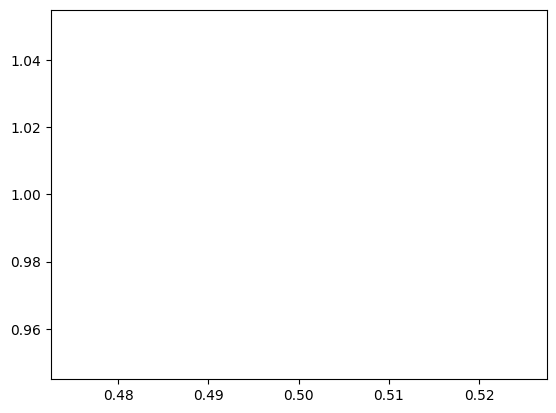

In [14]:
plot_example_1()

* As mentioned in Sec. 6, any quantum channel (completely positive trace preserving map) $\mathcal{B}$ has a diamond norm $|| \mathcal{B}||_{\diamond} = 1$. The numerics above simply confirm this fact in the case of a qubit depolarizing channel. In what follows we discuss the advantage of using entanglement to distinguish quantum channels.

### Example 2: Distinguishing Depolarizing from Identity

In the introduction state at the top of this notebook, let $\mathcal{B}_1$ be the qubit identity channel $\mathcal{I}$ and $\mathcal{B}_2$ be the qubit depolarizing channel
\begin{equation}
    \Delta(\rho) = \lambda \rho + \frac{(1-\lambda)}{2} \rm Tr(\rho) I,
\end{equation}
where $-1/3 \leq \lambda \leq 1$.

In [15]:
#Example 2. Using the primal formulation
def example_2(p):
    upsBA = cj_mat(1)

    thetaBA = cj_mat(p)

    gamma2BA = upsBA - thetaBA  #Primal SDP
    #Constants
    #----------
    gamma2Pic = pic.Constant("gamma2BA", gamma2BA)
    
    shpBA = np.shape( gamma2Pic )
    shpB = np.shape(pic.partial_trace(gamma2Pic, subsystems=(1),dimensions=2))
    shpA = np.shape(pic.partial_trace(gamma2Pic, subsystems=(0),dimensions=2))
    iMatB = pic.Constant('Ib', np.eye(shpB[0]))
    
    #Variables
    #----------
    rhoPic = pic.HermitianVariable("rhoA", shpA)
    sigPic = pic.HermitianVariable("sigA", shpA)
    XPic = pic.ComplexVariable("X", shpBA)
    
    prob2P = pic.Problem()
        
    #Constraint
    #----------
    prob2P.add_constraint(((iMatB @ rhoPic & XPic ) // (XPic.H & iMatB @ sigPic)) >> 0)
    prob2P.add_constraint(pic.trace(rhoPic) == 1)
    prob2P.add_constraint(pic.trace(sigPic) == 1)
    
    #Objective
    #----------
    obj = pic.trace(gamma2Pic | XPic).real
    
    prob2P.set_objective('max',obj)

    #Solve the problem using mosek as a cvxopt
    prob2P.solve(verbosity=False,solver='cvxopt')
    #Solver claims to have found optimal saolution
    dNorm2P =  prob2P.value
    #Example 2 Dual Formulation
    #Constants
    #----------
    iMatA = pic.Constant('Ia', np.eye(shpA[0]))
    
    #Variables
    #----------
    NPicBA = pic.HermitianVariable("Nba", shpBA)
    MPicBA = pic.HermitianVariable("Mba", shpBA)
    mu = pic.RealVariable("mu")
    nu = pic.RealVariable("nu")
    prob2D = pic.Problem()
        
    #Constraint
    #----------
    prob2D.add_constraint(((NPicBA & -gamma2Pic) // (-gamma2Pic.H & MPicBA)) >> 0)
    
    NPicA = pic.partial_trace(NPicBA,subsystems=(0),dimensions=2)
    MPicA = pic.partial_trace(MPicBA,subsystems=(0),dimensions=2)
    
    prob2D.add_constraint(MPicA<<mu*iMatA)
    prob2D.add_constraint(NPicA<<nu*iMatA)
    
    #Objective
    #----------
    obj = (mu + nu)/2
    
    prob2D.set_objective('min',obj)
    #Solve the problem using mosek as a cvxopt
    prob2D.solve(verbosity=False,solver='cvxopt')
    #Solver claims to have found optimal solution
    dNorm2D =  prob2D.value
    # print('Diamond Norm distance between identity and equal probability Pauli error Channel')
    # print('Using Primal SDP = ', dNorm2P)
    # print('Using DualSDP = ', dNorm2D)
    # print('Difference between primal and dual values', abs(dNorm2D - dNorm2P))
    pE = (1 + dNorm2D/2)/2
    # print('Probability of distinguishing with an entangled input s* = ', pE)
    lmVal = 1.-4.*p/3.
    # print('Probability of distinguishing without an entangled input q* = ', (3 - lmVal)/4)
    return pE, (3 - lmVal)/4

In [21]:
def plot_example_2():
    entangled_probs = []
    non_entangled_probs = []
    p_vals = [0.75]

    # for p in np.arange(0.0, 1.0, 0.05):
    #     p_vals.append(p)

    for p in p_vals:
        entangled_prob, non_entangled_prob = example_2(p)
        entangled_probs.append(entangled_prob)
        non_entangled_probs.append(non_entangled_prob)

    print(entangled_probs)
    print(non_entangled_probs)
    print(min(non_entangled_probs))
    print(len(p_vals))
    x = np.array(p_vals)
    y = np.array(non_entangled_probs)
    print(y)
    print(x.shape, y.shape)
    plt.plot(x, y)
    plt.show()

[0.5937499999462881]
[0.75]
0.75
1
[0.75]
(1,) (1,)


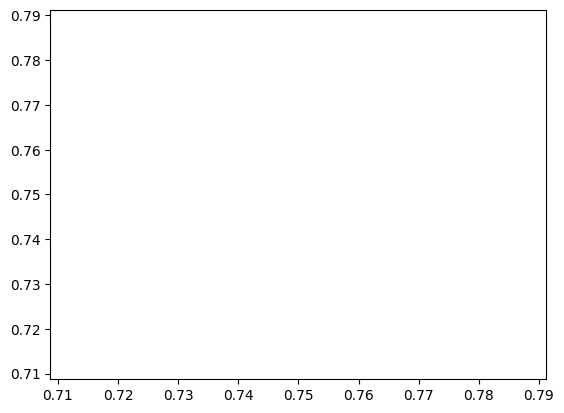

In [22]:
plot_example_2()

The value pE obtained above is in agreement with algebraic value $s^* = (7 - 3\lambda)/8$ stated in Sec.6. This value is larger than $q^* = (3-\lambda)/4$, the probability of distinguishing without entangled inputs.

### Example 3: Distinguishing Werner-Holevo channels
\begin{equation}
\mathcal{B}_1(\rho) = \frac{1}{d+1} \big( \rm Tr(\rho) I + \rho^T\big), 
\quad \text{and} \quad
\mathcal{B}_2(\rho) = \frac{1}{d-1} \big( \rm Tr(\rho) I - \rho^T\big). 
\end{equation}
Who have Choi-Jamiolkowski representations 
\begin{equation}
\mathcal{J}_{ba}(\mathcal{B}_1) =  \frac{1}{d+1}( I \otimes I + S_{ba}), 
\quad \text{and} \quad
\mathcal{J}_{ab}(\mathcal{B}_2) = \frac{1}{d-1}( I \otimes I - S_{ba}), 
\end{equation}
resp., where $S_{ba} |i \rangle |j \rangle = |j \rangle |i \rangle$. We compute their diamond norm distance

\begin{equation}
|| \mathcal{B}_1 -  \mathcal{B}_2 ||_{\diamond},
\end{equation}

using which the probability $s^* = \frac{1}{2}(1 + \frac{1}{2}|| \mathcal{B}_1 -  \mathcal{B}_2 ||_{\diamond})$ is be computed with relative ease.


In [ ]:
d = 3
iMatJoint = np.eye(d*d)


In [ ]:
wMatrix = np.zeros(shape=(d*d,d*d))
for i in range(d):
    for j in range(d):
        k1 = i*d + j
        k2 = j*d + i
        wMatrix[k1,k2] = 1.

In [ ]:
thBA = (iMatJoint + wMatrix)/(d+1)
psiBA = (iMatJoint - wMatrix)/(d-1)

In [ ]:
#Example 3 using the primal formulation

#Constants
#----------
gamma3Pic = pic.Constant("gammaBA", thBA - psiBA)
shpBA = np.shape( gamma3Pic )


shpB = np.shape(pic.partial_trace(gamma3Pic, subsystems=(1),dimensions=d))
shpA = np.shape(pic.partial_trace(gamma3Pic, subsystems=(0),dimensions=d))
iMatB = pic.Constant('Ib', np.eye(shpB[0]))

#Variables
#----------
rhoPic = pic.HermitianVariable("rhoA", shpA)
sigPic = pic.HermitianVariable("sigA", shpB)
XPic = pic.ComplexVariable("X", shpBA)


prob3P = pic.Problem()
    
#Constraint
#----------
prob3P.add_constraint(((iMatB @ rhoPic & XPic) // (XPic.H & iMatB @ sigPic)) >> 0)
prob3P.add_constraint(pic.trace(rhoPic) == 1)
prob3P.add_constraint(pic.trace(sigPic) == 1)

#Objective
#----------
obj = pic.trace(gamma3Pic | XPic).real

prob3P.set_objective('max',obj)

In [ ]:
#User readable view of the problem being composed in PICOS'
print(prob3P)

In [ ]:
#Solve the problem using mosek as a cvxopt
prob3P.solve(verbosity=False,solver='cvxopt')

In [ ]:
#Solver claims to have found optimal solution
dNorm3P =  prob3P.value

In [ ]:
#Example 3 Dual Formulation
#Constants
#----------
iMatA = pic.Constant('Ia', np.eye(shpA[0]))

#Variables
#----------
NPicBA = pic.HermitianVariable("Nba", shpBA)
MPicBA = pic.HermitianVariable("Mba", shpBA)
mu = pic.RealVariable("mu")
nu = pic.RealVariable("nu")


prob3D = pic.Problem()
    
#Constraint
#----------
prob3D.add_constraint(((NPicBA & -gamma3Pic) // (-gamma3Pic.H & MPicBA)) >> 0)

NPicA = pic.partial_trace(NPicBA,subsystems=(0),dimensions=d)
MPicA = pic.partial_trace(MPicBA,subsystems=(0),dimensions=d)

prob3D.add_constraint(MPicA<<mu*iMatA)
prob3D.add_constraint(NPicA<<nu*iMatA)

#Objective
#----------
obj = (mu + nu)/2

prob3D.set_objective('min',obj)

In [ ]:
#User readable view of the problem being composed in PICOS'
print(prob3D)


In [ ]:
#Solve the problem using mosek as a cvxopt
prob3D.solve(verbosity=False,solver='cvxopt')

In [ ]:
#Solver claims to have found optimal solution
dNorm3D =  prob3D.value

In [ ]:
print('Diamond Norm distance between identity and equal probability Pauli error Channel')
print('Using Primal SDP = ', dNorm3P)
print('Using DualSDP = ', dNorm3D)
print('Difference between primal and dual values', abs(dNorm3D - dNorm3P))


In [ ]:
pE = (1 + dNorm3D/2)/2
print('Probability of distinguishing with an entangled input s* = ', pE)
print('Probability of distinguishing without an entangled input q* = ', .5 + 1/(d+1))

The value pE obtained above is in agreement with algebraic value $s^* = 1$ stated in Sec.6. This value is larger than $q^* = \frac{1}{2} + \frac{1}{d+1}$, the probability of distinguishing without entangled inputs.